In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from scipy.interpolate import interp1d
import sys
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point, Polygon
import shapely.speedups
import os
shapely.speedups.enable()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore Future deprecation warning
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

from classes import boundaries as bd
from classes import functions as fcy
from classes import snag_MTF_func as sg

# Plot settings
plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)
colors = ["windows blue", "amber", "green", "dusty purple", "cyan", "electric pink"]
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
sns.set_palette(sns.xkcd_palette(colors))
colors = ['C'+str(i) for i in range(len(colors))]


%matplotlib inline
%config Completer.use_jedi = False 

In [4]:
#---------------#
#  Import data  #
#---------------#

#--- Climate 
climate_data_list = ['CRUclim','CRUNCEPv7','CHELSA30s', 'WorldClim30s','WorldClim10m']
climate_data = climate_data_list[1]

cols = ['X coords','Y coords','MAT','MAP','MTF basis','Continent','Country','Region','Site name','Mortality','Reference']


#--- Site MTF
site_mtf = sg.MTF_database_import('data/MTF_database.xlsx','Site_MTF',engine=True)
site_mtf.loc[site_mtf['Site name'].isna(),['Site name']] = ''
site_mtf.loc[site_mtf['Y coords'].isna(),['Y coords']] = ''
site_mtf.loc[site_mtf['X coords'].isna(),['X coords']] = ''
site_mtf['MAT'] = site_mtf[(climate_data,'MAT')]
site_mtf['MAP'] = site_mtf[(climate_data,'MAP')]
site_mtf_cp = site_mtf.copy()
site_mtf = site_mtf.groupby(['Reference','Continent','Country','Region','Site name']).first().reset_index()
site_mtf = site_mtf.loc[:,cols]
site_mtf.columns = site_mtf.columns.get_level_values(0)
site_mtf = site_mtf.dropna(subset=['X coords','Y coords'])

site_mtf.MAP = site_mtf.MAP.div(100)

# Funtion to convert coordinates into Points for geopandas plotting
def f(x):  
    return Point((x[0], x[1]))

site_mtf.loc[:, 'geometry'] = site_mtf.loc[:,['MAT', 'MAP']].apply(f,axis=1)

site_mtf = gpd.GeoDataFrame(site_mtf, geometry='geometry')



#--- Biomes        
biomes = pd.read_csv('data/Whittaker_biomes_digitised.csv', header=[0,1])
biome_names = biomes.columns.levels[0]

polygones = []
for i in range(len(biome_names)):
    x = biomes[biome_names[i]].dropna().X.tolist()
    y = biomes[biome_names[i]].dropna().div(10).Y.tolist()
    polygones.append(Polygon([(i,j) for i,j in zip(x,y)]))    
    
biomes_gdf = gpd.GeoDataFrame([biome_names,polygones]).T
biomes_gdf.columns = ['biome', 'geometry']
biomes_gdf.biome = biomes_gdf.biome.str.replace('_',' ').str.capitalize()
biomes_gdf.biome[6] = 'Temperate grassland/ desert'
biomes_gdf.biome[2] = 'Temperate deciduous forest'
colors_biome = np.array([[255,211,120,255],
                         [225,180,79,255],
                         [170,211,141,255],
                         [56,110,68,255],
                         [129,185,52,255],
                         [153,204,143,255],
                         [226,132,97,255],
                         [110,159,112,255],
                         [181,209,231,255],
                        ]) / np.tile(np.array([256,254,254,255]),len(biomes_gdf)).reshape(9,4)
s = biomes_gdf.biome.str.len().sort_values(ascending=False).index
biomes_gdf = biomes_gdf.reindex(s).reset_index(drop=True)      
display(biomes_gdf )
from matplotlib.colors import ListedColormap
newcmp = ListedColormap(colors_biome)


newcmp = ListedColormap(sns.color_palette(sns.color_palette("Greys",9), as_cmap=True))



#--- Sites 
sites = site_mtf.copy() #pd.read_excel('data/MTF_database.xlsx', sheet_name='Site_information', engine='openpyxl')
sites['X coords'] = pd.to_numeric(sites['X coords'])
sites['Y coords'] = pd.to_numeric(sites['Y coords'])
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get site geometry data
sites.loc[:,'geometry'] = pd.DataFrame({'geometry':list(zip(sites['X coords'].astype('float'),
                                                            sites['Y coords'].astype('float')))}).geometry
sites.loc[:,'geometry'] = sites['geometry'].apply(Point)

sites_gdf = gpd.GeoDataFrame(sites, geometry='geometry')
sites_gdf.crs = {'init': 'EPSG:4326'}
sites_gdf.to_crs('epsg:4326')
print(sites_gdf.columns)
# Including the continent in the database
sites_gdf = gpd.sjoin(sites_gdf, world[['geometry', 'continent']], how='left', op='within')


sites_gdf.head()

,biome,geometry
0,Temperate coniferous forest,"POLYGON ((3.79310 16.09040, 3.92659 17.35593, ..."
1,Temperate grassland/ desert,"POLYGON ((-7.64182 0.76836, -6.35150 1.62712, ..."
2,Temperate deciduous forest,"POLYGON ((3.83760 16.18079, 4.63849 17.67232, ..."
3,Tropical seasonal forest,"POLYGON ((19.81090 23.36723, 19.63293 12.56497..."
4,Tropical rainforest,"POLYGON ((19.81090 23.32203, 21.27920 34.53107..."
5,Subtropical desert,"POLYGON ((-7.86429 0.67797, 15.62848 2.98305, ..."
6,Savanna,"POLYGON ((19.63293 12.56497, 29.44383 10.66667..."
7,Tundra,"POLYGON ((-14.49388 1.53672, -14.22692 1.98870..."
8,Taiga,"POLYGON ((-2.70300 12.15819, -1.59066 13.83051..."


Index(['X coords', 'Y coords', 'MAT', 'MAP', 'MTF basis', 'Continent',
       'Country', 'Region', 'Site name', 'Mortality', 'Reference', 'geometry'],
      dtype='object')


,X coords,Y coords,MAT,MAP,MTF basis,Continent,Country,Region,Site name,Mortality,Reference,geometry,index_right,continent
0,24.366667,67.666667,0.0,4.053,c,Europe,Finland,Lappland,Lappland,Other,Aakala2010CoarseDynamics,POINT (24.36667 67.66667),151.0,Europe
1,44.166667,63.000000,0.8,5.977,c,Europe,Russia,Arkhangelsk,Arkhangelsk,Other,Aakala2010CoarseDynamics,POINT (44.16667 63.00000),18.0,Europe
2,30.366667,68.300000,-0.6,5.769,c,Europe,Russia,Murmansk,Murmansk,Fire,Aakala2010CoarseDynamics,POINT (30.36667 68.30000),18.0,Europe
3,-122.010272,43.786010,8.3,10.050,count,North America,USA,Oregon,Torrey-Charlton Research Natural Area - consum...,Fire,Acker2013DynamicsForest,POINT (-122.01027 43.78601),4.0,North America
4,-122.010272,43.786010,8.3,10.050,count,North America,USA,Oregon,Torrey-Charlton Research Natural Area - partia...,Fire,Acker2013DynamicsForest,POINT (-122.01027 43.78601),4.0,North America


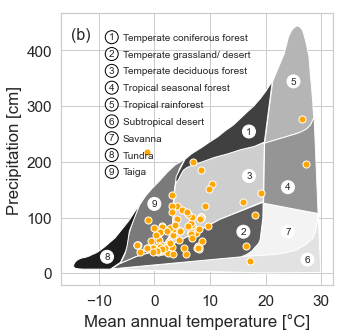

In [5]:
biomes_gs = gpd.GeoSeries(polygones)
fsize = 6
tdict = {'fontweight':800}


ax = biomes_gs.plot(figsize=(5,5), cmap=newcmp, alpha=1)

#for i in range(len(data_df_list_gdf)):
#    data_df_list_gdf[i].plot(ax=ax, edgecolor='k', markersize=40, alpha=0.5)

# Selecting CRU obs
site_mtf.plot(ax=ax, edgecolor='w', color='orange',
                             markersize=50, alpha=1)    

labels = [item.get_text() for item in ax.get_yticklabels()]
labels = [j+'0'  for i,j in enumerate(labels)]
labels[1] = '0'
ax.set_yticklabels(labels)

coords = [(17,25),    # Temperate coniferous
          (16,7),     # Temperate grassland
          (17,17),    # Temperate deciduous
          (24,15),    # Tropical seasonal
          (25,34),    # Tropical rainforest
          (27.5,2),   # Subtropical desert
          (24,7),     # Savanna
          (-8.5,2.5), # Tundra
          (-0,12)     # Taiga
         ]

#--- Biome legend
end  = 0.93
step = 0.05
x_position = 0.32
y_position = np.arange(end-9*step, end,step)[::-1]
for b in range(len(biomes_gdf)):
    plt.annotate(str(b+1),(x_position,y_position[b]), xycoords="figure fraction", 
             bbox={"boxstyle":"circle", "facecolor":"white", 
                   'edgecolor':'black','pad':0.2
                  })
    plt.annotate(str(b+1),coords[b],ha="center",
             bbox={"boxstyle" : "circle", "facecolor":"white", 'pad':0.2
                   #'edgecolor':'black'
                  })
    plt.annotate(biomes_gdf.biome[b], (x_position+0.04,y_position[b]-0.001), xycoords="figure fraction",)

plt.annotate('(b)', (-15,42), fontsize=16)

plt.xlabel('Mean annual temperature [°C]')
plt.ylabel('Precipitation [cm]')


#if plot:

plt.show()

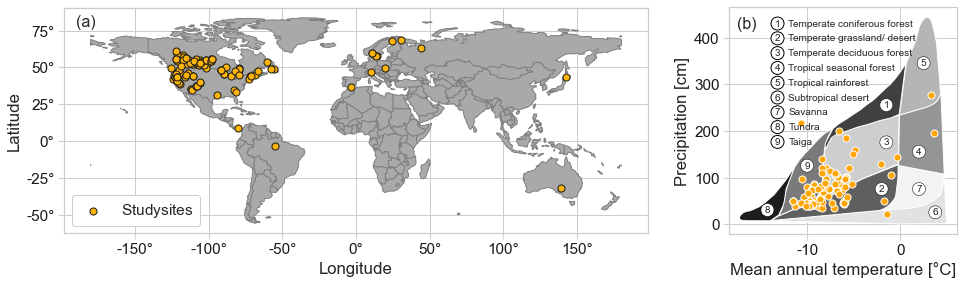

In [6]:
from matplotlib import gridspec
import warnings
#sns.set_context("paper", font_scale=2)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left']   = True
plt.rcParams['xtick.color']  = 'lightgrey'
plt.rcParams['ytick.color']  = 'lightgrey'



fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 0.78]
                       #width_ratios=[3, 1.0]
                      )

ax0 = plt.subplot(gs[0])
world[world['continent'] != 'Antarctica'].plot(edgecolor='grey', color='darkgrey',ax=ax0,aspect='equal')
#world.plot(edgecolor='grey', color='darkgrey',ax=ax0)
sites_gdf.plot(ax=ax0, color='C1', edgecolor='k', markersize=50, alpha=1,
                                              aspect='equal', label='$Study sites$')
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax0.legend(loc='lower left')
leg = ax0.get_legend()

frame = leg.get_frame()
frame.set_alpha(1)


biomes_gs = gpd.GeoSeries(polygones)
fsize = 6
tdict = {'fontweight':800}

ax1 = plt.subplot(gs[1])
biomes_gs.plot(figsize=(5,5), cmap=newcmp, alpha=1, ax=ax1,aspect='equal')

#for i in range(len(data_df_list_gdf)):
#    data_df_list_gdf[i].plot(ax=ax, edgecolor='k', markersize=40, alpha=0.5)
site_mtf.plot(ax=ax1, edgecolor='w', color='orange',
                             markersize=50, alpha=1,aspect='equal')  
#site_mtf[site_mtf.Mortality == 'Fire'].plot(ax=ax1, edgecolor='w', color='red', markersize=50, alpha=1)  

labels = [item.get_text() for item in ax1.get_yticklabels()]
labels = [j+'0'  for i,j in enumerate(labels)]
labels[1] = '0'
ax1.set_yticklabels(labels)

coords = [(17,25),    # Temperate coniferous
          (16,7),     # Temperate grassland
          (17,17),    # Temperate deciduous
          (24,15),    # Tropical seasonal
          (25,34),    # Tropical rainforest
          (27.5,2),   # Subtropical desert
          (24,7),     # Savanna
          (-8.5,2.5), # Tundra
          (-0,12)     # Taiga
         ]

#--- Biome legend
end  = 0.98
step = 0.065
x_position = 0.2
y_position = np.arange(end-9*step, end,step)[::-1]
for b in range(len(biomes_gdf)):
    ax1.annotate(str(b+1),(x_position,y_position[b]), xycoords="axes fraction", 
             bbox={"boxstyle":"circle", "facecolor":"white", 
                   'edgecolor':'black','pad':0.2
                  })
    ax1.annotate(str(b+1),coords[b], ha="center",
             bbox={"boxstyle" : "circle", "facecolor":"white", 'pad':0.2,
                   'edgecolor':'black', 'linewidth':0.5
                  })
    ax1.annotate(biomes_gdf.biome[b], (x_position+0.06,y_position[b]-0.0001), xycoords="axes fraction",)

ax0.annotate('(a)', (-190,78), fontsize=16)
ax1.annotate('(b)', (-15,42), fontsize=16)

ax1.set_xlabel('Mean annual temperature [°C]')
ax1.set_ylabel('Precipitation [cm]')


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ax0.grid(True, axis='both')
    ax0.set_yticklabels([str(i)+'°' for i in np.arange(-75,100,25)],color='k')
    ax0.set_xticklabels([str(i)+'°' for i in np.arange(-200,200,50)],color='k')
    ax0.set_xlabel('Longitude')
    
    ax1.grid(True, axis='both')
    ax1.set_xticklabels(np.arange(-20,40,10),color='k')
    ax1.set_yticklabels(np.arange(-100,500,100)  ,color='k')
    ax1.set_xlabel('Mean annual temperature [°C]')



#plt.subplots_adjust(wspace=0.18)
#plt.savefig('Figure2_study_locations_whittaker_biomes.png', dpi=300, bbox_inches='tight')

plt.show()

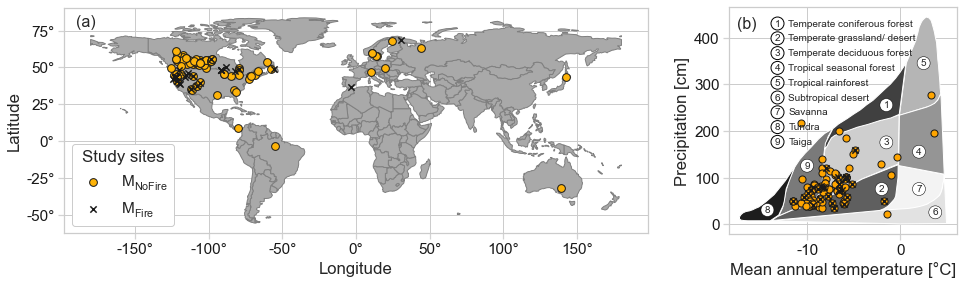

In [7]:
from matplotlib import gridspec
import warnings
#sns.set_context("paper", font_scale=2)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left']   = True
plt.rcParams['xtick.color']  = 'lightgrey'
plt.rcParams['ytick.color']  = 'lightgrey'

fire_color = 'k'


fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 0.78]
                       #width_ratios=[3, 1.0]
                      )

ax0 = plt.subplot(gs[0])

ms = 60
ms1 = 40
world[world['continent'] != 'Antarctica'].plot(edgecolor='grey', color='darkgrey',ax=ax0,aspect='equal')
#world.plot(edgecolor='grey', color='darkgrey',ax=ax0)
sites_gdf[sites_gdf.Mortality != 'Fire'].plot(ax=ax0, color='C1', edgecolor='k', markersize=ms, alpha=1,
                                              aspect='equal', label='$M_{NoFire}$', marker='o')
sites_gdf[sites_gdf.Mortality == 'Fire'].plot(ax=ax0, color=fire_color, edgecolor='k', markersize=ms1, alpha=1,
                                              aspect='equal',label='$M_{Fire}$', marker='x')
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Longitude')
ax0.legend(loc='lower left')
leg = ax0.get_legend()
leg.set_title('Study sites')
frame = leg.get_frame()
frame.set_alpha(1)


biomes_gs = gpd.GeoSeries(polygones)
fsize = 6
tdict = {'fontweight':800}

ax1 = plt.subplot(gs[1])
biomes_gs.plot(figsize=(5,5), cmap=newcmp, alpha=1, ax=ax1,aspect='equal')

#for i in range(len(data_df_list_gdf)):
#    data_df_list_gdf[i].plot(ax=ax, edgecolor='k', markersize=40, alpha=0.5)
site_mtf.plot(ax=ax1, edgecolor='k', color='orange', marker='o',
                             markersize=50, alpha=1,aspect='equal')  
site_mtf[site_mtf.Mortality == 'Fire'].plot(ax=ax1, edgecolor='k', 
                                            color=fire_color, markersize=40, alpha=1, marker='x')  

labels = [item.get_text() for item in ax1.get_yticklabels()]
labels = [j+'0'  for i,j in enumerate(labels)]
labels[1] = '0'
ax1.set_yticklabels(labels)

coords = [(17,25),    # Temperate coniferous
          (16,7),     # Temperate grassland
          (17,17),    # Temperate deciduous
          (24,15),    # Tropical seasonal
          (25,34),    # Tropical rainforest
          (27.5,2),   # Subtropical desert
          (24,7),     # Savanna
          (-8.5,2.5), # Tundra
          (-0,12)     # Taiga
         ]

#--- Biome legend
end  = 0.98
step = 0.065
x_position = 0.2
y_position = np.arange(end-9*step, end,step)[::-1]
for b in range(len(biomes_gdf)):
    ax1.annotate(str(b+1),(x_position,y_position[b]), xycoords="axes fraction", 
             bbox={"boxstyle":"circle", "facecolor":"white", 
                   'edgecolor':'black','pad':0.2
                  })
    ax1.annotate(str(b+1),coords[b], ha="center",
             bbox={"boxstyle" : "circle", "facecolor":"white", 'pad':0.2,
                   'edgecolor':'black', 'linewidth':0.5
                  })
    ax1.annotate(biomes_gdf.biome[b], (x_position+0.06,y_position[b]-0.0001), xycoords="axes fraction",)

ax0.annotate('(a)', (-190,78), fontsize=16)
ax1.annotate('(b)', (-15,42), fontsize=16)

ax1.set_xlabel('Mean annual temperature [°C]')
ax1.set_ylabel('Precipitation [cm]')


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    ax0.grid(True, axis='both')
    ax0.set_yticklabels([str(i)+'°' for i in np.arange(-75,100,25)],color='k')
    ax0.set_xticklabels([str(i)+'°' for i in np.arange(-200,200,50)],color='k')
    ax0.set_xlabel('Longitude')
    
    ax1.grid(True, axis='both')
    ax1.set_xticklabels(np.arange(-20,40,10),color='k')
    ax1.set_yticklabels(np.arange(-100,500,100)  ,color='k')
    ax1.set_xlabel('Mean annual temperature [°C]')



#plt.subplots_adjust(wspace=0.18)
plt.savefig('Figure3_study_locations_whittaker_biomes.png', dpi=300, bbox_inches='tight')

plt.show()